# Clean data, normalise and concatenate plugin results for different images.

## Purpose:
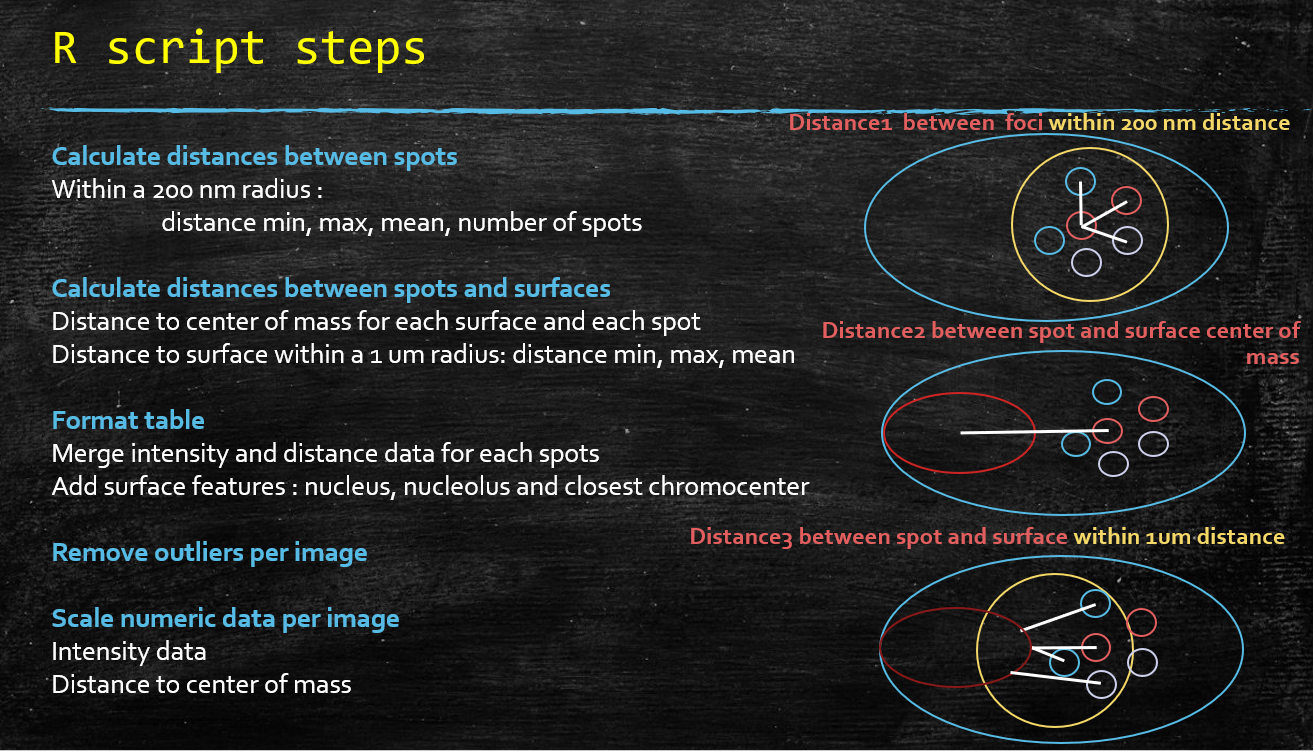


In [1]:
library(matrixStats) # rowMins()
require( spam) #to calculate distances
library(data.table)
library(ggplot2)
library(reshape2)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Warning message in FUN(X[[i]], ...):
“failed to assign RegisteredNativeSymbol for toeplitz to toeplitz since toeplitz is already defined in the ‘spam’ namespace”Spam version 2.1-1 (2017-07-02) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Attaching package: ‘reshape2’

The following objects are masked from ‘package:data.table’:

    dcast, melt



### CalculateSpotDistance()
* Calculate distance between spots

### CalculateSpotSurfaceDistance()
* Calculate distances between spots and surfaces

In [2]:
#Create function to calcualte distances for a postiion table
CalculateSpotDistance<-function(PositionTableX, PositionTableY, DistanceThreshold, fileName, plotType){
  #Calculate nearest distance
  #Here Posistion Y: DATA1, because we collect @entries with @colindices
  ds <- nearest.dist(x=PositionTableX, y=PositionTableY, method = "euclidean", delta=DistanceThreshold, upper=NULL)
  #Plot histogram = optional
    ##for linux
  tiff(paste("/home/nani/Documents/Plots/", fileName,"_",plotType ,".tiff", sep=""))
    ##for windows Z:\\Result0309\\s20_Wt"
  #tiff(paste("C:\\Documents\Plots\\", fileName,"_",plotType ,".tiff", sep=""))
    ########
  hist(diff( ds@entries),main=paste("Distances frequency within delta - ", plotType, sep=""), sub=fileName)
  dev.off() 
  #Get data frame containing min, max, mean distance to next point and number of spots close by (below delta threshold)
  ds@colindices<-ds@colindices[ds@entries>0]
  ds@entries<-ds@entries[ds@entries>0]
  dt <- as.data.table(ds@colindices)[, list(list(ds@entries[.I])), by = ds@colindices]
  CollectDist <- data.frame(SpotId = unlist(dt$`ds@colindices`),
                            NumbSpot = unlist(dt[,list(lapply(V1,length))]),
                            MeanDist = unlist(dt[,list(lapply(V1,mean))]),
                            MinDist = unlist(dt[,list(lapply(V1,min))]), 
                            MaxDist = unlist(dt[,list(lapply(V1,max))])
  )
  colnames(CollectDist)<-c("SpotId", "NumbSpot", "MeanDist", "MinDist", "MaxDist")
  CollectDist
}

#Calculate distance from each surface = set a high delta
CalculateSpotSurfaceDistance<-function(SpotPosition, SurfacePosition, SurfaceFeat){
  #Note: Here delta is set a high value 100: I want all the distances
  #STEP1 : Calculate the distance to center of masses of nucleus, of the nucleolus and all the chromocenters
  FirstTab<-SurfacePosition[1:2,] #this table contains postions for Nucleus and nucleolus only
  CC<-SurfacePosition[3:nrow(SurfacePosition),] #this one for the CC
  CCF<-SurfaceFeat[3:nrow(SurfaceFeat),] #Get CC features
  meanCC<-colMeans(CC) #calculate average position for all CC
  FirstTab<-rbind(FirstTab, meanCC)
  ds <- nearest.dist(x=SpotPosition, y=FirstTab, method = "euclidean", delta=100, upper=NULL)
  ds <-data.frame(as.matrix(ds))
  #STEP2: Get minimum distance spot-CC for each spot
  ds2 <- nearest.dist(x=SpotPosition, y=CC, method = "euclidean", delta=100, upper=NULL)
  MinDistance <- rowMins(as.matrix(ds2))
  MinDistanceIndex <- as.matrix(apply( ds2, 1, which.min)) #I need the index as well to get features of the closest CC
  rm(ds2)
  ds<-cbind(ds, MinDistance)
  FeatVect<-CCF[MinDistanceIndex,]
  rownames(FeatVect)<-seq(1, nrow(FeatVect))
  ds<-cbind(ds, FeatVect)
  colnames(ds)<-c("Nucleus", "Nucleolus", "MeanCC", "ClosestCC",paste0(names(FeatVect), "CC"))
  ds$SpotId <- seq(1, nrow(ds)) #Since I transform spam into a matrix, I get the row = SpotId
  ds
}
clamp <- function(x, xmax) { ifelse(x<=xmax, x, xmax) }

### ProcessOneImage()
* Read both spot position and intensity data from simualted (from <b>XTSimulateRandomSpots.py</b>) and observed (from <b>XTCountSpotPerShell.py</b>) spots for each image and concatenate them
* Calculate distance between spots
* Read surface result (from <b>XTSegmentNuclei.py</b>) and calculate distance between surfaces and spots
* Add nucleus and nucleolus features to data frame
* Replace outliers
* Scale data specific for each spot
* Return resulting data frame


In [21]:
ProcessOneImage<-function(MotherFolder, ImageId,ImageIdVert, FileName, DataType, IsLinux){
  MaskId <- 1 # Only processing spots simulated outside of the CC and nucleolus
  isSimulated<-DataType=="Simulated"
  BaseFolder <- ifelse(isSimulated,"XTSimulateRandomSpots_Result", "XTCountSpotPerShell_Result" )
  SimPath <- paste(MotherFolder,BaseFolder, sep=ifelse(IsLinux, "/", "\\"))
  n <- 3 #declaring number of segemented channels
  delta <- 0.2 #declaring the highest distance threshold for distance between foci
  vdelta <- 1 #declaring the highest distance threshold for distance between surface vertices and foci, higher than 1um I get iteration and memory allocation error
  #STEP1: READ POSITION AND INTENSITY FOR EACH FOCI
  Data1 <- data.frame(matrix(,nrow=0, ncol=3)) #will contain positions of spots
  Intensity <- data.frame(matrix(,nrow=0, ncol=n+1)) #will contain intensities of spots (n+DAPI)
  SimN <- c()#vector to keep track of simulation ID / segmentation channel
  CollectSepSpots <- as.list(rep("", n))
  ListSegChan <-c() #vector to keep track of segmentation channel for observed spots, =0 for simulated ones
  Spottype <- ifelse(isSimulated, -1,1) #keep track of difference between simulated and segmented spots
  for (ch in seq(0,n-1)) #This loop over the different channels/simulations (total: 3)
    {      
    Fname <- ifelse(isSimulated, 
                    paste0("Position_SP0_ST",MaskId , "_Sml",ch,"_Sim_10000_", ImageId,".csv"),
                    paste0("Position_SP",ch , "_Obs_", ImageId,".csv")) 
    FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
    Spots <- read.csv(file=FilePath, header = TRUE, sep = ",")
    if (isSimulated)
    {#in XTSimulateRandomSpots_Result, Position df is transposed
        Spots <- as.data.frame(t(Spots)) 
    }
    Fname <- ifelse(isSimulated,
                    paste0("Intensity_SP0_ST",MaskId , "_Sml",ch,"_Sim_10000_", ImageId,".csv"),
                    paste0("Intensity_SP",ch , "_Obs_", ImageId,".csv"))
    FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
    Int <- read.csv(file=FilePath, header = TRUE, sep = ",")
    if (DataType=="Segmented")
    {#make sure I don't have any artifact segmentation 
        Spots <- Spots[Int[[ch+1]]>0, ] 
        Int <- Int[Int[[ch+1]]>0, ]  
    } 
    print(paste0("Sp", dim(Spots)))
    Data1 <- rbind(Data1, Spots)
    print(paste0("Sp", dim(Int)))
    Intensity <- rbind(Intensity, Int)
    SimN <- c(SimN, rep(Spottype*(ch+1),nrow(Int))) 
    SegChan <- ifelse(rep(isSimulated,nrow(Int)),
                      rep(0,nrow(Int)),
                      Int[[ch+1]])
    ListSegChan <- c(ListSegChan, SegChan) 
    CollectSepSpots[[ch+1]] <- Spots
    rm(Int, Spots) #Free RAM
    print(ch)
  }
  names(Intensity) <- paste0("IntensityCh", seq(0,n))
  Intensity$FociType <- SimN
  Intensity$SegmentChannel <- ListSegChan
  Intensity$SpotId <- seq(1, nrow(Data1))ListSegChan
  rm(ListSegChan, SimN) #Free RAM  
  #STEP2: CALCULATE DISTANCE BETWEEN EACH SPOT AND SURFACES
  for (surfName in c("Nucleus","Chromocenters","Nucleolus")){
    ColName <- paste0(surfName, "Dist")
    Fname <- paste0("XTGetSurfaceVertices_Result/", surfName, " Vertices_",ImageIdVert,".csv")
    FilePath <- paste(MotherFolder,Fname, sep=ifelse(IsLinux, "/", "\\"))
    Vertices <- read.csv(file=FilePath, header = TRUE, sep = ",")
    res<-CalculateSpotDistance(Vertices, Data1, vdelta, FileName, surfName) 
    Features <- paste0(surfName, c("_NumbSpot","_MeanDist", "_MinDist", "_MaxDist"))
    colnames(res) <- c("SpotId", Features)
    Intensity <- merge(Intensity, res,by = "SpotId", all.x=TRUE)
    rm(Vertices) #Free RAM  
    print(surfName)
  }
  #STEP3: CALCULATE DISTANCE BETWEEN FOCI
  for (ch in seq(1, n))
    {
    res<-CalculateSpotDistance(CollectSepSpots[[ch]], Data1, delta, FileName, paste("Channel", ch,sep=""))
    Features <- paste0(paste0("Sp", ch), c("NumbSpot","MeanDist", "MinDist", "MaxDist"))
    colnames(res) <- c("SpotId", Features)
    Intensity <- merge(Intensity, res, all=TRUE)
  }
  rm(CollectSepSpots, res) #free RAM space
  #STEP4 : CALCULATE DISTANCE BETWEEN EACH SPOT AND CENTER OF MASS OF EACH SURFACE
  Fname <- paste0("SurfaceFeatures_",ImageId ,".csv")  
  FilePath <- paste(SimPath, Fname, sep=ifelse(IsLinux, "/", "\\")) 
  Surface <- read.csv(file=FilePath, header = TRUE, sep = ",")
  Pos <- Surface[2:4]
  Feat <- Surface[5:9]
  SurfSPot<-CalculateSpotSurfaceDistance(Data1, Pos, Feat)
  Intensity<- merge(Intensity, SurfSPot, all=TRUE)
  rm(SurfSPot, Pos,  Surface, Data1) #Free RAM
  #STEP5: ADD COLUMNS WITH NUCLEUS AND NUCLEOLUS FEATURES
  NucleusF<-Feat[rep(1, nrow(Intensity)),] #this table contains nucleus features 
  names(NucleusF)<-paste0("N1", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  NucleusF<-Feat[rep(2, nrow(Intensity)),] #this table contains nucleolus features
  names(NucleusF)<-paste0("N2", names(NucleusF))
  Intensity<-cbind(Intensity, NucleusF)
  Intensity$File=FileName
  rm(NucleusF)
  #STEP6: REMOVE OUTLIERS
  drops <- c("SpotId","FociType", 'File') 
  IntensityRf<-Intensity[ , !(names(Intensity) %in% drops)]
  Intensity.quantiles <- apply(IntensityRf, 2, function(x, prob=0.9) { quantile(x, prob, names=F, na.rm=TRUE) })
  for (j in 1:ncol(IntensityRf)) {
      IntensityRf[,j] <- clamp(IntensityRf[,j], Intensity.quantiles[j])  
  }
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], IntensityRf)
  rm(Intensity.quantiles, IntensityRf)
  #STEP7: SCALE NUMERIC SPOT FEATURES
  drops <- c("SpotId","FociType",'N1Volume','N1IntensityCh0','N1IntensityCh1', 'N1IntensityCh2', 'N1IntensityCh3', 'N2Volume','N2IntensityCh0','N2IntensityCh1', 'N2IntensityCh2','N2IntensityCh3', 'File',"Sp1MeanDist", "Sp1MinDist", "Sp1MaxDist", "Sp2MeanDist", "Sp2MinDist", "Sp2MaxDist", "Sp3MeanDist", "Sp3MinDist", "Sp3MaxDist") # these features are not to be scaled per image
  NormDf<-Intensity[ , !(names(Intensity) %in% drops)]
  NormDf<-as.data.frame(scale(NormDf))
  Intensity<-cbind(Intensity[ , (names(Intensity) %in% drops)], NormDf)
  Intensity
}

## Step 1 : Test run on one image

In [6]:
FolderPath= #*Add folder path*
Index_of_observed_Image=#*Add existing index example*
Index_of_simulated_Image=#*Add existing index example*
IsLinux = # TRUE for linux or Mac, FALSE for Windows*
res<-ProcessOneImage(FolderPath, Index_of_observed_Image,Index_of_simulated_Image, "FileName","Segmented", IsLinux)
head(res)

[1] 0
[1] 1
[1] 2


### SelectFiles()
* Read the all the filenames in all folders 
* Select only filenames that has both simulated (from <b>XTSimulateRandomSpots.py</b>) and observed data (from <b>XTCountSpotPerShell.py</b>)
* Read ploidy result (from <b>XTNucleiPloidy.py</b>)
* Select results of images contained in both XTSimulateRandomSpots_Result and XTCountSpotPerShell_Result
* Save a .csv file containing two columns: filenames and ploidy index


In [19]:
SelectFiles <- function(FolderPath, IsLinux)
    {
      Data1 <- data.frame(matrix(,nrow=0, ncol=2)) #will contain positions of spots
      for (SubFolder in c(1,2,3,4,5))
        {
        FilePath<- paste(MotherFolder,SubFolder,  "XTCountSpotPerShell_Result","FileName.csv" , sep=ifelse(IsLinux, "/", "\\")) 
        OBsdf <- read.csv(file=FilePath, header = TRUE, sep = ",")
        FilePath<- paste(MotherFolder,SubFolder,  "XTSimulateRandomSpots_Result","FileName.csv" , sep=ifelse(IsLinux, "/", "\\")) 
        Simdf <- read.csv(file=FilePath, header = TRUE, sep = ",")
        df<-merge(OBsdf, Simdf, all = FALSE)
        df$FolderID<-SubFolder
        Data1<-rbind(Data1, df)
      }
    names(Data1)<-c("FileName", "FolderID")
    FilePath<- paste(MotherFolder,"XTNucleiPloidy_Result", "XTNucleiPloidy_Result.csv" , sep=ifelse(IsLinux, "/", "\\"))
    PLoidyDf <- read.csv(file=FilePath, header = TRUE, sep = ",")
    Data1<-merge(Data1, PLoidyDf, all = FALSE)
    Data1<-Data1[, names(Data1)%in%c("FileName","FolderID", "ClusterId")]
    Data1
}

In [22]:
FileName<-SelectFiles(FolderPath, IsLinux)
FilePath=paste(FolderPath, "FileNames.csv", sep=ifelse(IsLinux, "/", "\\"))
write.csv(FileName, file = FilePath, quote=FALSE, row.names = FALSE)

## Step 2 : Manually rate the segmentation quality good (true) bad (false)
* Open FileNames.csv, add a column SegmentationOk
* index the segmentation quality (TRUE/FALSE) based on the snapshots in XTCountSpotPerShell.py

In [9]:
FilePath=paste(FolderPath, "FileNames.csv", sep=IsLinux) 
SelectedIMages <- read.csv(file=FilePath, header = TRUE, sep = ",")
head(SelectedIMages)

FileName,ClusterId,SegmentationOk,FolderID
s20_wt_aa_series005.ims,P0,1,1
s20_wt_ab_series006.ims,P0,1,1
s20_wt_ac_series007.ims,P0,1,1
s20_wt_ad_series008.ims,P0,1,1
s20_wt_ae_series009.ims,P0,1,1
s20_wt_am_series017.ims,P0,1,2


In [11]:
### Here only images index True for SegmentationOk are selected
SelectedIMages<-SelectedIMages[SelectedIMages$SegmentationOk==1, names(SelectedIMages)%in%c("FileName", "ClusterId", "FolderID")]

head(SelectedIMages)

FileName,ClusterId,FolderID
s20_wt_aa_series005.ims,P0,1
s20_wt_ab_series006.ims,P0,1
s20_wt_ac_series007.ims,P0,1
s20_wt_ad_series008.ims,P0,1
s20_wt_ae_series009.ims,P0,1
s20_wt_am_series017.ims,P0,2


### ProcessOneFOlder()
* Process results of each images, contained in each subfolder in list list_of_folders stored under HighPath
* Select files in FileNames.csv


In [70]:
ProcessOneFOlder<-function(HightPath, SelectedIMages, list_of_folders, DataType, IsLinux){
  MaskID <- 1 #I only process spots that are simulated outside of chromocenters and nucleolus
  for (highFol in list_of_folders)
    {
    Result <- data.frame(matrix(,nrow=0, ncol=51)) #will contain intensities of spots (n+DAPI)
    #GET FILENAMES IN filename FILE CONTAINING ALL FILES AND THEIR PLODY ID
    MotherFolder <- paste(HightPath, highFol, sep=ifelse(IsLinux, "/", "\\"))
    AllImagesInFolder <- SelectedIMages$FileName[SelectedIMages$FolderID==highFol]  
    #GET FILENAME IN PLUGIN XTSimulateRandomSpots_Result FOLDER
    BasePath <-ifelse(DataType=="Simulated","XTSimulateRandomSpots_Result", "XTCountSpotPerShell_Result")
    FilePath<- paste(MotherFolder,BasePath,"FileName.csv", sep=ifelse(IsLinux, "/", "\\"))
    FileName <- read.csv(file=FilePath, header = TRUE, sep = ",")
    FileNameSim <- FileName$X0
    #GET FILENAME IN PLUGIN XTGetSurfaceVertices_Result FOLDER
    FilePath<- paste(MotherFolder,"XTGetSurfaceVertices_Result","FileName.csv", sep=ifelse(IsLinux, "/", "\\"))
    FileName <- read.csv(file=FilePath, header = TRUE, sep = ",")
    FileNameVert <- FileName$X0
    for(ImageId in AllImagesInFolder){
        SimID <- match(ImageId,FileNameSim)
        ImageIdVert <- match(ImageId,FileNameVert)
        res<-ProcessOneImage(MotherFolder, SimID,ImageIdVert, ImageId, DataType, IsLinux)
        Result<-rbind(Result, res)
        rm(res)
      }
    Nmes <- paste0("MLResult_", DataType, ".csv")
    FilePath <- paste(MotherFolder, Nmes, sep=ifelse(IsLinux, "/", "\\"))
    write.csv(Result, file = FilePath, quote=FALSE, row.names = FALSE) 
    rm(Result)
    }
  }


## Step 3: Run batch process

In [71]:
list_of_folders=#*Add vector of folder names saved under FolderPath here* 
Spot_type = #*"Simulated" for simulates spots or "Segmented" for segmented spots*
ProcessOneFOlder(FolderPath, SelectedIMages, list_of_folders, Spot_type, OS_Specifc_seperator)

[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 0
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 1
[1] "Sp10000" "Sp3"    
[1] "Sp10000" "Sp4"    
[1] 2
[1] "Sp10000" "Sp3"    
[1] 